# Example: MA(100,200) strategy on Storebrand

This notebook demonstrates how to:

- Load Storebrand historical price data from the repository,
- Compute 100- and 200-day simple moving averages,
- Create a lagged trading signal (1-day lag) to avoid lookahead bias,
- Compute strategy simple returns and run the `test_strategy()` helper from `src/test_strategy.py` to run CAPM and plot diagnostics.

Run cells sequentially. The example is intentionally explicit and well-documented for testing and teaching purposes.

In [1]:
# Imports and setup
import sys
from pathlib import Path

# Ensure project root is on sys.path so we can import src.test_strategy
proj_root = Path('..').resolve()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.test_strategy import test_strategy

plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# Data loader for Storebrand historical prices
from typing import Tuple

def load_storebrand() -> pd.DataFrame:
    """Load Storebrand historical price data from the repository.

    The repository contains two possible CSV files (a split export); we try both and concatenate.
    Returns a DataFrame indexed by date with at least a price column named 'Price' or 'Close'.
    """
    candidates = [
        Path('..') / 'tests' / 'Storebrand Stock Price History.csv',
        Path('..') / 'tests' / 'Storebrand Stock Price History (1).csv',
        Path('..') / 'tests' / 'Storebrand Stock Price History (2).csv',
    ]

    dfs = []
    for p in candidates:
        if p.exists():
            try:
                d = pd.read_csv(p, index_col=0, parse_dates=True)
                dfs.append(d)
            except Exception as e:
                print(f"Warning: failed to read {p}: {e}")

    if not dfs:
        raise FileNotFoundError('No Storebrand CSV files found in ../tests. Please place the CSV files there.')

    df = pd.concat(dfs).sort_index().groupby(level=0).first()

    # locate price column
    if 'Price' in df.columns:
        price_col = 'Price'
    elif 'Close' in df.columns:
        price_col = 'Close'
    else:
        # pick first numeric column as fallback
        num_cols = df.select_dtypes(include=[np.number]).columns
        if len(num_cols) == 0:
            raise KeyError('No numeric price column found in Storebrand data')
        price_col = num_cols[0]

    df = df[[price_col]].rename(columns={price_col: 'Price'})
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    return df


In [3]:
# Inspect and preprocess data

df = load_storebrand()
print(f"Loaded Storebrand data: {len(df)} rows. Date range: {df.index.min().date()} to {df.index.max().date()}")

# Handle missing values: forward-fill then drop remaining missing
df['Price'] = df['Price'].ffill().bfill()

# show head
df.head()


Loaded Storebrand data: 6547 rows. Date range: 2000-01-03 to 2026-01-29


,Price
Date,
2000-01-03,51.67
2000-01-04,48.73
2000-01-05,47.89
2000-01-06,47.89
2000-01-07,48.73


In [4]:
# Compute MA100 and MA200 and lagged signal (1-day) to avoid lookahead bias

price = df['Price']
df['MA100'] = price.rolling(window=100, min_periods=1).mean()
df['MA200'] = price.rolling(window=200, min_periods=1).mean()

# Raw signal: 1 if short MA > long MA, else 0
# We then shift the signal by 1 to lag it (decisions executed next day)
df['signal_raw'] = (df['MA100'] > df['MA200']).astype(int)
df['signal'] = df['signal_raw'].shift(1).fillna(0).astype(int)

# Simple returns from prices (used as input to test_strategy)
df['ret_simple'] = price.pct_change().fillna(0)

# Strategy simple returns (apply lagged signal)
df['strat_ret_simple'] = df['signal'] * df['ret_simple']

print(df[['Price','MA100','MA200','signal_raw','signal','ret_simple','strat_ret_simple']].tail())


            Price    MA100     MA200  signal_raw  signal  ret_simple  \
Date                                                                   
2026-01-23  168.7  159.721  149.0135           1       1   -0.019756   
2026-01-26  170.3  159.892  149.2530           1       1    0.009484   
2026-01-27  170.5  160.084  149.5110           1       1    0.001174   
2026-01-28  168.9  160.280  149.7455           1       1   -0.009384   
2026-01-29  168.5  160.456  149.9965           1       1   -0.002368   

            strat_ret_simple  
Date                          
2026-01-23         -0.019756  
2026-01-26          0.009484  
2026-01-27          0.001174  
2026-01-28         -0.009384  
2026-01-29         -0.002368  


In [5]:
# Wrapper that calls src.test_strategy.test_strategy

def run_example(tc: float = 0.0):
    """Prepare inputs and call the reusable `test_strategy` in `src/test_strategy.py`.

    Parameters
    - tc: transaction cost (not used here, kept for experiment). test_strategy handles no-tc by default.

    Returns the results dict returned by `test_strategy`.
    """
    strategy_returns = df['strat_ret_simple'].values  # simple returns sequence
    underlying_prices = [df['Price'].values]
    underlying_names = ['STOREBRAND']
    dates = df.index

    results = test_strategy(
        strategy_returns=strategy_returns,
        underlying_prices=underlying_prices,
        underlying_names=underlying_names,
        dates=dates,
        data_dir='../data/processed',
    )

    # print concise numeric summary
    m = results['model']
    print('\nCAPM Regression Summary (pooled excess returns):')
    print(m.summary())

    # show the two generated figures
    # for fig in results['figures']:
    #     display(fig)
    #     plt.show()

    return results


                            OLS Regression Results                            
Dep. Variable:           excess_strat   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1134.
Date:                Fri, 30 Jan 2026   Prob (F-statistic):          9.58e-229
Time:                        14:07:23   Log-Likelihood:                 17611.
No. Observations:                6323   AIC:                        -3.522e+04
Df Residuals:                    6321   BIC:                        -3.520e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.668e-05      0.000     -0.461      0.6

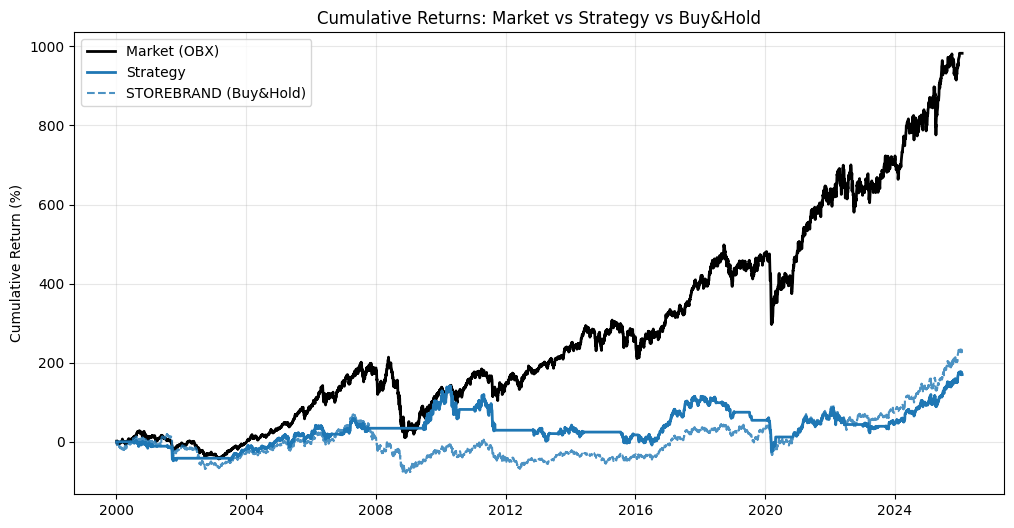

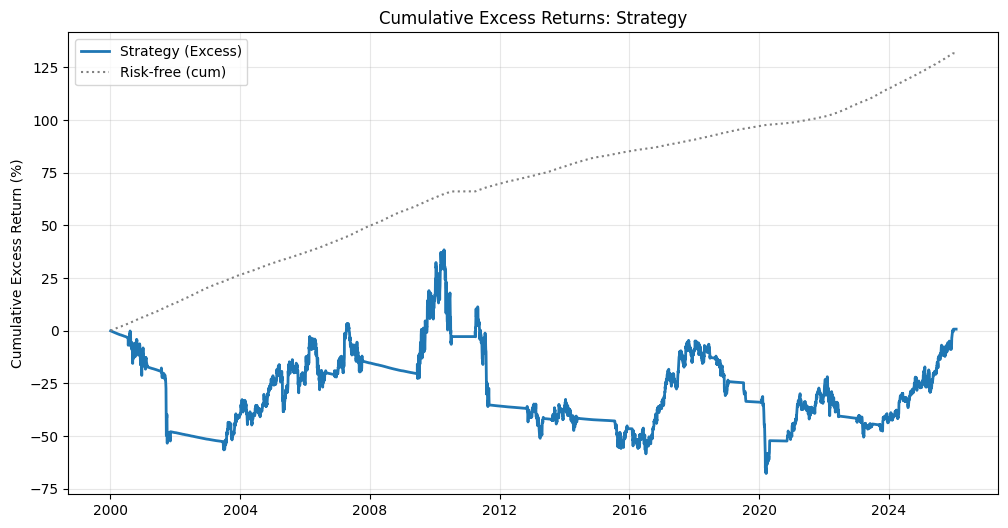

In [6]:
# Execute the example
results = run_example()

# optional: inspect returned series keys
print('\nReturned series keys:', list(results['series'].keys()))
